# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

# Feature engineering

In [3]:
# Feature engineering for date-based features
def prepare_date_features(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    
    # Extract date-related features
    df['Year'] = df['Policy Start Date'].dt.year
    df['Month'] = df['Policy Start Date'].dt.month
    df['Day'] = df['Policy Start Date'].dt.day
    
    # Create cyclic features for months and days
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    
    df.drop('Policy Start Date', axis=1, inplace=True)
    return df

# Apply feature engineering
train_df = prepare_date_features(train_df)
test_df = prepare_date_features(test_df)

# Target Distribution Before and After Log Transformation

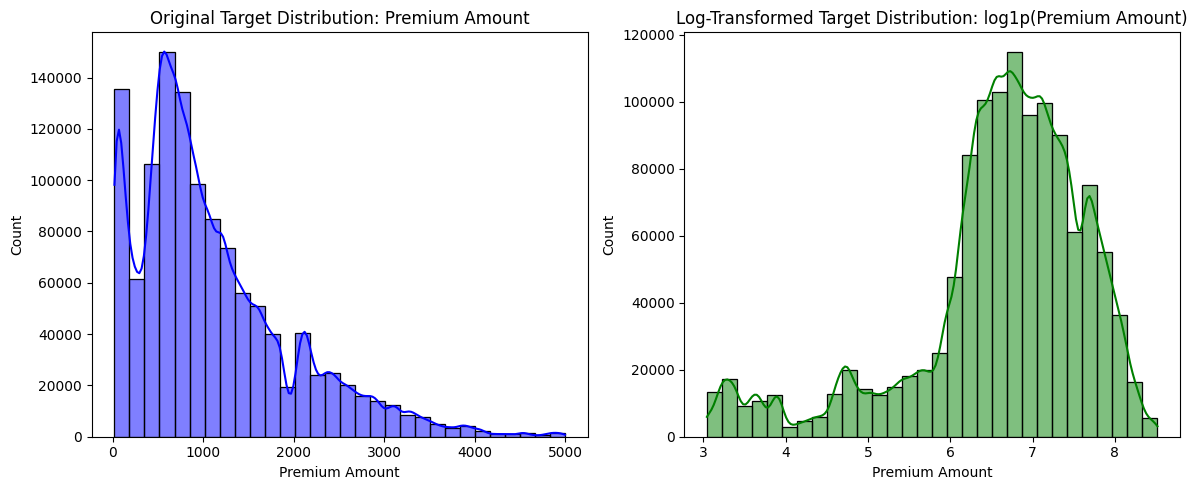

In [4]:
# Compare Target Distribution Before and After Log Transformation
def compare_target_distribution(y, target_name="Target"):
    y_log = np.log1p(y)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(y, kde=True, bins=30, color="blue")
    plt.title(f"Original Target Distribution: {target_name}")
    plt.subplot(1, 2, 2)
    sns.histplot(y_log, kde=True, bins=30, color="green")
    plt.title(f"Log-Transformed Target Distribution: log1p({target_name})")
    plt.tight_layout()
    plt.show()

y = train_df['Premium Amount']
compare_target_distribution(y, target_name="Premium Amount")

# Apply log transformation to the target
y_log = np.log1p(y)

# Numerical and categorical features

In [5]:
# Define numerical and categorical features
numerical_features = [
    'Age', 'Annual Income', 'Number of Dependents', 
    'Health Score', 'Previous Claims', 'Vehicle Age', 
    'Credit Score', 'Insurance Duration', 
    'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos'
]

categorical_features = [
    'Gender', 'Marital Status', 'Education Level', 
    'Occupation', 'Location', 'Policy Type', 
    'Customer Feedback', 'Smoking Status', 
    'Exercise Frequency', 'Property Type'
]

# Mssing value

In [6]:
# Check missing values and categorical encoding before preprocessing
def check_data_before_preprocessing(df, numerical_features, categorical_features):
    print("=== Missing Values BEFORE Preprocessing ===")
    print(df[numerical_features + categorical_features].isnull().sum())

    print("\n=== Data Types ===")
    print(df.dtypes)

check_data_before_preprocessing(train_df, numerical_features, categorical_features)

=== Missing Values BEFORE Preprocessing ===
Age                      18705
Annual Income            44949
Number of Dependents    109672
Health Score             74076
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Month_sin                    0
Month_cos                    0
Day_sin                      0
Day_cos                      0
Gender                       0
Marital Status           18529
Education Level              0
Occupation              358075
Location                     0
Policy Type                  0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

=== Data Types ===
id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation       

# Preprocessing pipeline

In [7]:
# Preprocessing pipelines for numerical and categorical data
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

# Separate features
X = train_df.drop(columns=['Premium Amount', 'id'])
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_df.drop(columns=['id']))

# Confirm transformed features
print(f"Transformed dataset shape: {X_processed.shape}")

Transformed dataset shape: (1200000, 45)


# Missing value after pipline

In [8]:
# Check transformed data after preprocessing
def check_data_after_preprocessing(preprocessor, X, numerical_features, categorical_features):
    # Get transformed feature names
    feature_names = (
        preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
        preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    
    print("\n Missing Values AFTER Preprocessing# Check if any missing values remain
    
    print("\n Transformed Feature Names")
    print(feature_names)

check_data_after_preprocessing(preprocessor, X_processed, numerical_features, categorical_features)


=== Missing Values AFTER Preprocessing ===
0

=== Transformed Feature Names ===
['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Gender_Female', 'Gender_Male', 'Marital Status_Divorced', 'Marital Status_Married', 'Marital Status_Single', 'Marital Status_Unknown', "Education Level_Bachelor's", 'Education Level_High School', "Education Level_Master's", 'Education Level_PhD', 'Occupation_Employed', 'Occupation_Self-Employed', 'Occupation_Unemployed', 'Occupation_Unknown', 'Location_Rural', 'Location_Suburban', 'Location_Urban', 'Policy Type_Basic', 'Policy Type_Comprehensive', 'Policy Type_Premium', 'Customer Feedback_Average', 'Customer Feedback_Good', 'Customer Feedback_Poor', 'Customer Feedback_Unknown', 'Smoking Status_No', 'Smoking Status_Yes', 'Exercise Frequency_Daily', 'Exercise Frequency_Monthly', 'Exercise Frequency_Rarely', 'Exercise Frequenc

# Train/val split

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train_log, y_val_log = train_test_split(X_processed, y_log, test_size=0.2, random_state=42)

# Hyperparameter optimization with Optuna

In [10]:
# Optuna Hyperparameter Optimization
def objective(trial):
    params = {
        'tree_method': 'gpu_hist',
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train_log, 
        eval_set=[(X_val, y_val_log)],
        early_stopping_rounds=50, verbose=False
    )
    y_pred_log = model.predict(X_val)
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2024-12-16 11:32:39,877] A new study created in memory with name: no-name-352d3e46-e461-4c2d-acb3-9e5c5dd72bbc
[I 2024-12-16 11:32:44,712] Trial 0 finished with value: 1.0568938699736747 and parameters: {'learning_rate': 0.16941099161362452, 'max_depth': 10, 'subsample': 0.5455135359188233, 'colsample_bytree': 0.6386148415630328, 'n_estimators': 561}. Best is trial 0 with value: 1.0568938699736747.
[I 2024-12-16 11:32:48,792] Trial 1 finished with value: 1.1099298549547971 and parameters: {'learning_rate': 0.03474129617425138, 'max_depth': 6, 'subsample': 0.5310352389355226, 'colsample_bytree': 0.7271833433956434, 'n_estimators': 152}. Best is trial 0 with value: 1.0568938699736747.
[I 2024-12-16 11:32:53,617] Trial 2 finished with value: 1.063198695672517 and parameters: {'learning_rate': 0.03480546593257465, 'max_depth': 4, 'subsample': 0.6089744102155671, 'colsample_bytree': 0.5580822591149825, 'n_estimators': 259}. Best is trial 0 with value: 1.0568938699736747.
[I 2024-12-16 11

# Final model training

In [11]:
# Extract the best parameters
best_params = study.best_params
best_params['random_state'] = 42

# Train the final model with the best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_processed, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8769926967780808, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.019824855150976293, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=832, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Model evaluation

In [12]:
# Train Final Model
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_processed, y_log)

# Evaluate Model
y_pred_log = final_model.predict(X_processed)
y_pred = np.expm1(y_pred_log)  # Transform back to original scale

print("Model Metrics (log-transformed):")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_log, y_pred_log)):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_log, y_pred_log)):.4f}")
print(f"MAE: {mean_absolute_error(y_log, y_pred_log):.4f}")
print(f"R²: {r2_score(y_log, y_pred_log):.4f}")

Model Metrics (log-transformed):
RMSLE: 1.0098

Model Metrics (original scale):
RMSE: 903.9687
MAE: 603.0500
R²: -0.0921


# Feature importance visualization

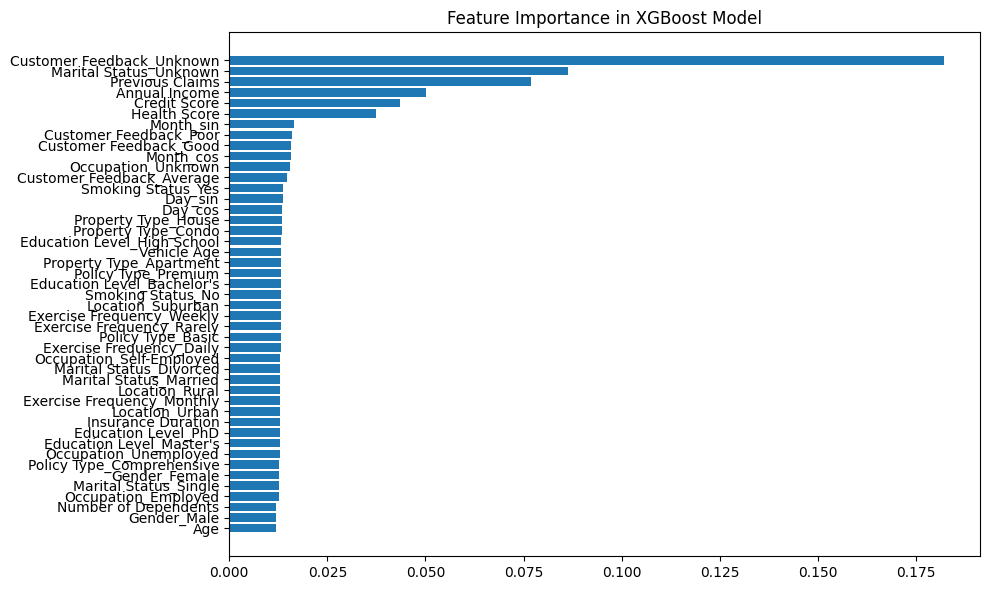

In [13]:
# Extract feature names
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Feature Importance in XGBoost Model")
plt.tight_layout()
plt.show()

# Submission preparation

In [14]:
# Submission Preparation
test_predictions_log = final_model.predict(test_processed)
test_predictions = np.expm1(test_predictions_log)

submission = pd.DataFrame({
    'id': test_df['id'], 
    'Premium Amount': test_predictions.round(3)
})
submission.to_csv('xgboost_submission_log1p.csv', index=False)
print("Submission file saved: 'xgboost_submission_log1p.csv'")

Submission file saved: 'xgboost_submission_log1p.csv'
